In [126]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [127]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset


from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
df = pd.read_csv('/content/drive/MyDrive/SOFT_COMP_LAB/Dataset.csv')
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [131]:
df = df.sample(frac = 1)

from sklearn.model_selection import train_test_split
text = df['Text'].values
label = df['Sentiment'].values
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.20, random_state=36)

# One hot embedding + CNN

In [133]:
 from keras.preprocessing.text import Tokenizer
 tokenizer = Tokenizer()
 tokenizer.fit_on_texts(text_train)
 Xcnn_train = tokenizer.texts_to_sequences(text_train)
 Xcnn_test = tokenizer.texts_to_sequences(text_test)
 vocab_size = len(tokenizer.word_index)+1
 print(text_train[1])
 print(Xcnn_train[1]) 

As the coronavirus pandemic intensifies, adherents of the Financial Independence, Retire Early movement are doublinâ€¦ https://t.co/klzYRO889R
[34, 1, 62, 334, 2202, 4046, 6, 1, 626, 4047, 4048, 402, 2203, 37, 4049, 13, 11, 12, 4050]


In [134]:
 from keras.preprocessing.sequence import pad_sequences
 maxlen = 150
 Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
 Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
 print(Xcnn_train[0, :]) 

[ 855   90  855   48   65 4044    4   58  231 1010 2811 1822    2  596
  255  154 1105 1823 2812  156 2201 4045    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [135]:
from keras.models import Sequential
from keras import layers 
import tensorflow as tf

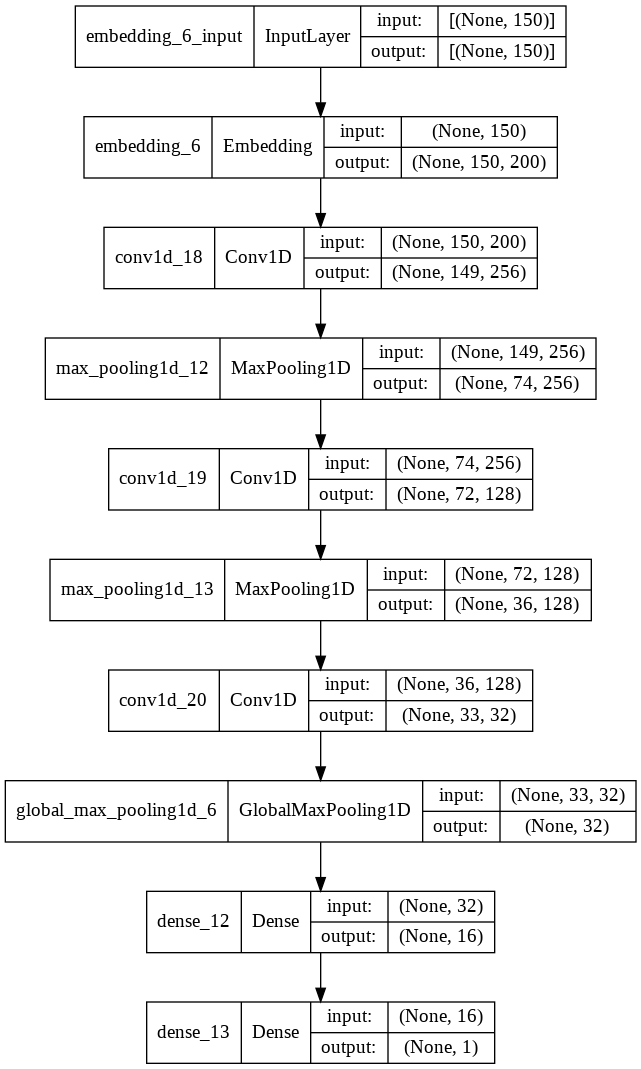

In [136]:
seed = 170204036
torch.manual_seed(seed)
embedding_dim = 200
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
textcnnmodel.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=32, kernel_size=4, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(16, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

tf.keras.utils.plot_model(textcnnmodel, show_shapes = True, show_layer_names = True)


In [137]:
history = textcnnmodel.fit(Xcnn_train, label_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(Xcnn_test, label_test),
                    batch_size=10)
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = textcnnmodel.evaluate(Xcnn_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/50
464/464 [==============================] - 30s 62ms/step - loss: -12563.8975 - accuracy: 0.1973 - val_loss: -127673.2500 - val_accuracy: 0.3391
Epoch 2/50
464/464 [==============================] - 28s 60ms/step - loss: -8417391.0000 - accuracy: 0.2960 - val_loss: -29199866.0000 - val_accuracy: 0.2804
Epoch 3/50
464/464 [==============================] - 28s 61ms/step - loss: -253050736.0000 - accuracy: 0.3012 - val_loss: -518011424.0000 - val_accuracy: 0.2399
Epoch 4/50
464/464 [==============================] - 28s 61ms/step - loss: -2406985728.0000 - accuracy: 0.3046 - val_loss: -3373973504.0000 - val_accuracy: 0.2338
Epoch 5/50
464/464 [==============================] - 28s 61ms/step - loss: -11673586688.0000 - accuracy: 0.3066 - val_loss: -13153302528.0000 - val_accuracy: 0.2330
Epoch 6/50
464/464 [==============================] - 28s 61ms/step - loss: -38181109760.0000 - accuracy: 0.3195 - val_loss: -36490145792.0000 - val_accuracy: 0.2235
Epoch 7/50
464/464 [========

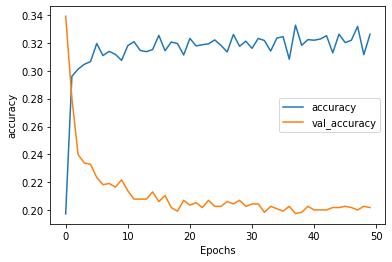

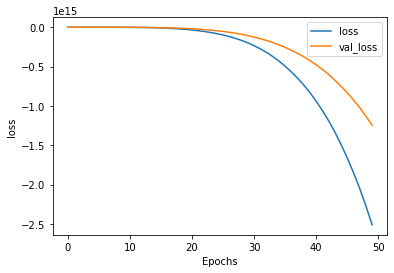

In [139]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [140]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

y_pred = textcnnmodel.predict(Xcnn_train)

y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose = 1)

145/145 [==============================] - 4s 30ms/step - loss: -2653112699453440.0000 - accuracy: 0.3459


In [141]:
print('Train Loss:', loss)
print('Train Accuracy:', accuracy_score(label_train, y_pred))
print('Train Precision:', precision_score(label_train, y_pred))
print('Train Recall:', recall_score(label_train, y_pred))
print('Train F1-score:', f1_score(label_train, y_pred))

Train Loss: -2653112699453440.0
Train Accuracy: 0.7012089810017271
Train Precision: 0.9756394640682094
Train Recall: 0.5437881873727087
Train F1-score: 0.6983435047951176


In [64]:
y_pred = textcnnmodel.predict(Xcnn_test)

y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

# BOW + NN

In [66]:
# get a word count per of text
def word_count(words):
    return len(words.split())

In [67]:
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
import nltk
import re 
import string
import pickle
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [68]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
print(stop_words)

{'how', 'into', "shouldn't", 'did', 'themselves', "didn't", 'doesn', 'it', 'the', 'didn', 'herself', 'out', 'ma', 'other', 'because', "shan't", 'not', 'being', 'does', 'for', "doesn't", "couldn't", 'whom', 'up', "wasn't", 'won', "she's", 'these', 'yourselves', 'now', 'should', 'same', 'been', 'than', 'again', 'me', 'but', 'a', 'most', 'will', 'off', 'so', 'through', 've', 'o', 'y', 'few', "mustn't", 'in', 'hers', 'at', 'was', 'only', "weren't", 'your', 'this', 'such', 'until', 'don', 'there', 'itself', 'are', 'can', 'she', 'where', "haven't", 'what', "hadn't", 'wasn', 'very', 'those', 'll', 'am', 'too', 'if', 'their', "wouldn't", "hasn't", 'needn', 'm', "you're", 'mightn', 'both', 'after', 's', 'has', 'mustn', 'had', 'our', 'theirs', "you'll", 'ourselves', 'i', "should've", 'shouldn', 'just', 'above', 'under', 'were', 'or', "don't", 'he', 'him', 'is', 'doing', 'who', 'have', "mightn't", 'during', 'haven', 'her', 'with', 'further', 't', 'd', 'we', "you've", 'ain', 'shan', "it's", 'from'

In [69]:
seed = 170204036
torch.manual_seed(seed)

In [70]:
df["Sentiment"] = df["Sentiment"].replace(-1,0)
df["Sentiment"].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

In [71]:
#Checking if any null values present
(df.isnull().sum() / len(df))*100

Text              0.0
Sentiment         0.0
processed_text    0.0
dtype: float64

In [72]:
ps = PorterStemmer()
lemma = WordNetLemmatizer()
stopwordSet = set(stopwords.words("english"))

In [73]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_text(text):
  # Lower Casing
    text = text.lower()
    text=text[1:]
    # Removing all URls 
    text = re.sub(urlPattern,'',text)
    # Removing all @username.
    text = re.sub(userPattern,'',text) 
    #Remove punctuations
    text = text.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(text)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopwordSet]
    #reducing a word to its word stem 
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = ps.stem(w)
        finalwords.append(word)
    return ' '.join(finalwords)   

In [74]:
df['processed_text'] = df['Text'].apply(lambda x: process_text(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [75]:
print(df.shape)
df

(5791, 3)


,Text,Sentiment,processed_text
5542,US Stock Markets End Over 2% Higher After Jump...,1,stock market end higher jump crude oil price
2290,JOE successful test of that 22-23 support I hi...,1,oe success test 2223 support highlight last week
1128,Did you like my IBM calls and GOOG calls from ...,1,id like ibm call goog call last night
428,user: DDD broke out from the bear flag to the ...,1,ser ddd broke bear flag upsid ot short underst...
2524,GD SV NEM ABX AY - The Price of Gold plunges t...,0,sv nem abx ay price gold plung sixmonth low
...,...,...,...
62,user Nice! Color me an INTC bull as well!,1,ser nice color intc bull well
335,yum down premarket through the cloud but has s...,0,um premarket cloud support 6275
4097,PK taking some off here,1,take
4259,AAP here come the Europeans.. maybe they will ...,1,ap come european mayb save us


In [76]:
cv = CountVectorizer(max_features = len(df))
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()

#X = torch.from_numpy(X).type(torch.LongTensor)
#y = torch.from_numpy(y).type(torch.LongTensor)

X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [77]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [104]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 256) 
        self.layer_3 = nn.Linear(256, 64)   
        self.layer_4 = nn.Linear(64, 1) 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        # self.flatten = nn.Flatten()

        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_4(x)
        logits = self.sigmoid(x)
        return logits

In [105]:
model = NeuralNetwork(len(df))
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [106]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)

loss_fn = loss_fn.to(device)

In [107]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [108]:
def trainModel(model, loss_fn, optimizer):
    model.train()

    batch = 256
    size = X_test.shape[0]

    loss = 0
    acc = 0
    

    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
    
      # Compute prediction 
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
         # print(f'Training Loss: {loss.item():.4f}', end="\r")
         # print(f'\tTraining Loss: {loss.item():.3f} | Training Acc: {acc.item()*100:.2f}%')
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [109]:
from numpy.lib.function_base import append

TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
    
        # Compute prediction error
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TN.append(1)         
       
            
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
      
    loss /= size
    acc /= size
    
    #print(f'Testing Loss: {loss}')
    #print(f'\t Val. Loss: {loss:.3f} |  Val. Acc: {acc*100:.2f}%')
  
    return loss, acc  

In [110]:
epochs = 10
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


	Train Loss: 0.014 | Train Acc: 1.21%
	 Val. Loss: 0.661 |  Val. Acc: 61.78%

	Train Loss: 0.014 | Train Acc: 1.21%
	 Val. Loss: 0.615 |  Val. Acc: 61.78%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.570 |  Val. Acc: 61.78%

	Train Loss: 0.014 | Train Acc: 1.21%
	 Val. Loss: 0.571 |  Val. Acc: 61.78%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.572 |  Val. Acc: 62.12%

	Train Loss: 0.014 | Train Acc: 1.21%
	 Val. Loss: 0.576 |  Val. Acc: 62.04%

	Train Loss: 0.014 | Train Acc: 1.21%
	 Val. Loss: 0.579 |  Val. Acc: 62.04%

	Train Loss: 0.014 | Train Acc: 1.21%
	 Val. Loss: 0.573 |  Val. Acc: 62.38%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.574 |  Val. Acc: 62.90%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.576 |  Val. Acc: 62.73%


In [111]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

In [112]:
acc=(TP+TN)/(TP+TN+FN+FP)
acc

0.7535806729939604

In [113]:
prec=TP/(TP+FP)
prec

0.7766778092054513

In [114]:
rec=TP/(TP+FN)
rec

0.8437150837988827

In [115]:
f1score=2*prec*rec/(prec+rec)
f1score

0.8088097469540769

# TF-IDF + NN

In [90]:
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()

X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [91]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [92]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 128) 
        self.layer_3 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        # self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [93]:
model = NeuralNetwork(len(df))
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [94]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_fn = loss_fn.to(device)

In [95]:
def binary_accuracy(preds, y):

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [96]:
def trainModel(model, loss_fn, optimizer):
    model.train()

    batch = 256
    size = X_test.shape[0]

    loss = 0
    acc = 0
    

    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
    
      # Compute prediction 
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
         # print(f'Training Loss: {loss.item():.4f}', end="\r")
         # print(f'\tTraining Loss: {loss.item():.3f} | Training Acc: {acc.item()*100:.2f}%')
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [97]:
from numpy.lib.function_base import append

TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
    
        # Compute prediction error
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TN.append(1)         
       
            
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
      
    loss /= size
    acc /= size
    
    #print(f'Testing Loss: {loss}')
    #print(f'\t Val. Loss: {loss:.3f} |  Val. Acc: {acc*100:.2f}%')
  
    return loss, acc

In [98]:
epochs = 20
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


	Train Loss: 0.014 | Train Acc: 1.21%
	 Val. Loss: 0.658 |  Val. Acc: 61.78%

	Train Loss: 0.014 | Train Acc: 1.21%
	 Val. Loss: 0.610 |  Val. Acc: 61.78%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.574 |  Val. Acc: 61.78%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.573 |  Val. Acc: 61.78%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.574 |  Val. Acc: 61.78%

	Train Loss: 0.014 | Train Acc: 1.21%
	 Val. Loss: 0.579 |  Val. Acc: 61.78%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.575 |  Val. Acc: 61.86%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.574 |  Val. Acc: 62.21%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.577 |  Val. Acc: 62.04%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.581 |  Val. Acc: 62.12%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.576 |  Val. Acc: 62.73%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.580 |  Val. Acc: 62.81%

	Train Loss: 0.013 | Train Acc: 1.21%
	 Val. Loss: 0.578 |  Val

In [99]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

In [100]:
acc=(TP+TN)/(TP+TN+FN+FP)
acc

0.7584555651423641

In [101]:
prec=TP/(TP+FP)
prec

0.7847208619000979

In [102]:
rec=TP/(TP+FN)
rec

0.839245810055866

In [103]:
f1score=2*prec*rec/(prec+rec)
f1score

0.8110679939261008